In [1]:
# Import basic packages
import numpy as np
import pandas as pd
# Import data processing package
from DataProcessing import *
# Import pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
# Import plot packages
import gspplot
from gspplot import *
import matplotlib.pyplot as plt
# Import graph packages
import gsp
import pygsp
from pygsp import graphs, filters, plotting, utils
# Import other packages
import os
from Learning import *
from operator import itemgetter 
import ipywidgets as widgets
import warnings; warnings.filterwarnings('ignore')

# 1  Data Processing

## 1.1 Read Data and Crop a Patch

In [2]:
path_cloud  = 'data/Vaihingen3D_Traininig.pts'
# Load dataset as pandas dataframe
cloud       = load_cloud(path_cloud)
newcloud    = cloud_preprocess(cloud)
# Crop a patch from cloud
patch       = crop_patch(newcloud, (150, 210), (200 , 260))

-------------------- Load Data ---------------------
Data Loading...
=> Done.
----------------------------------------------------
--------------- Data Pre-Processing ----------------
Drop duplicates...
=> Duplicates #: 40946, Ratio: 5.43% of the dataset.
Re-center the data...
=> Done.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[150, 210], y:[200, 260].
=> Points left for patch: 31239.
----------------------------------------------------


## 1.2 Data Visualization

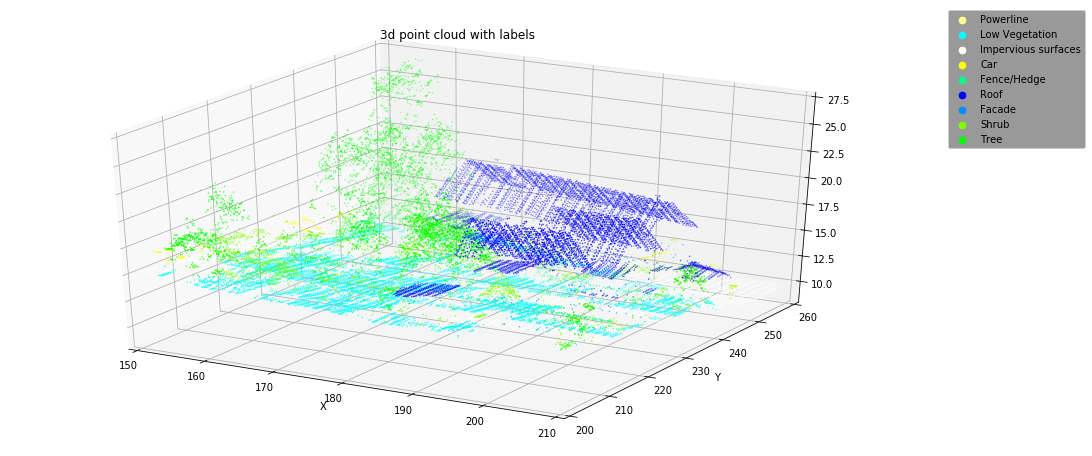

In [3]:
plot_graph_3D(patch, 
              figsize=(16, 8), 
              marksize=0.2, 
              markerscale=15, 
              xRange=(150, 210), 
              yRange=(200 , 260))

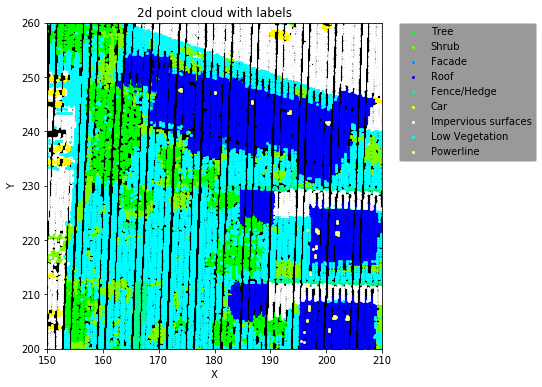

In [4]:
plot_graph_2D(patch, 
              figsize=(6, 6), 
              marksize=4,
              markerscale=1,
              xRange=(150, 210), 
              yRange=(200, 260))

# 2 Graph Construction 

## 2.1 Generating Graph

Five types of graph are generated in the following way:  
1) When type is '30nn', connect 30 nearest neighbors of a particular node.  
2) When type is 'r101', connect neighbors within the radius of 1.1.  

Then, it remains to calculate the weights:  
1) Gaussian: Use Euclidean distance. Weight is calculated by: $$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{2\sigma^2} \right)$$  
Where $\sigma$ is the mean value of all distances.

2) Binary: Set all weights to be 1 if connected.

3) Local: Comparing to Gaussian, only $\sigma$ changes here.$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma_i \sigma_j} \right)$$  
Where $\sigma_i$ is the distance between node i and its farthest neighbor, the same for node j.



### Use the Number of Neighbors

In [5]:
# 30nn, Gaussian kernel
G_30nn_Gaussain, l1 = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                    mode='distance', neightype='number', lap_type='combinatorial', norm=True)
# 30nn, Binary graph
G_30nn_Binary, l2   = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                    mode='connectivity', neightype='number', lap_type='combinatorial', norm=True)
# 30nn, Local scaling
G_30nn_Local, l3    = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                    mode='local', neightype='number', lap_type='combinatorial', norm=True)

### Use the Radius to Find Neighbors

In [6]:
# r1.1, Gassian kernel
G_r101_Gaussain, l4 = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                    mode='distance', neightype='radius', lap_type='combinatorial', norm=True)
# r1.1, Binary graph
G_r101_Binary, l5   = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                    mode='connectivity', neightype='radius', lap_type='combinatorial', norm=True)

# 3 POI detection

## 3.1 Mexican Hat Filter Construction

In [7]:
# Create graph list
graph_list  = [G_30nn_Gaussain, G_30nn_Binary, G_30nn_Local,
               G_r101_Gaussain, G_r101_Binary]
# Initialize filters dictionary
filter_key  = ['g_MH_30nn_Gaussain', 'g_MH_30nn_Binary', 'g_MH_30nn_Local', 
               'g_MH_r101_Gaussain', 'g_MH_r101_Binary']
filter_dict = dict.fromkeys(filter_key)
for i, idx in zip(filter_dict.keys(), range(5)):
    if 'nn' in i:
        filter_dict[i] = filters.MexicanHat(graph_list[idx], Nf=1+len([1.5]), lpfactor=1, scales=[1.5])
    else:
        filter_dict[i] = filters.MexicanHat(graph_list[idx], Nf=1+len([1.5]), lpfactor=1, scales=[1.5])

## 3.2 Visualization Filters

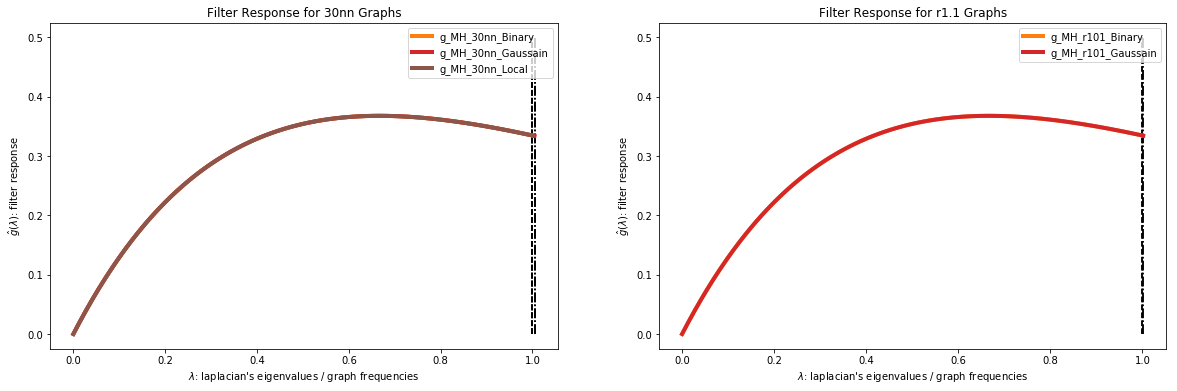

In [8]:
fig = plt.figure(figsize=(20, 6))

# Visualize filters constructed using number of Neighbors
ax1 = fig.add_subplot(121)
for i,j in zip(itemgetter(*[1, 0, 2])(list(filter_dict.keys())), range(3)):
    filter_dict[i].plot(ax=ax1, show_sum=False)
    ax1.lines.pop(j)
    ax1.vlines(G_30nn_Binary.lmax, 0, 0.5, 'k', '--')
    ax1.vlines(G_30nn_Gaussain.lmax, 0, 0.5, 'k', '-.')
    ax1.vlines(G_30nn_Local.lmax, 0, 0.5, 'k', ':')
    ax1.set_title("Filter Response for 30nn Graphs")
    ax1.legend(itemgetter(*[1, 0, 2])(list(filter_dict.keys())))
    
# Visualize filters constructed using radius to find neighbors
ax2 = fig.add_subplot(122)
for i,j in zip(itemgetter(*[4, 3])(list(filter_dict.keys())), range(2)):
    filter_dict[i].plot(ax=ax2, show_sum=False)
    ax2.lines.pop(j)
    ax2.vlines(G_r101_Binary.lmax, 0, 0.5, 'k', '--')
    ax2.vlines(G_r101_Gaussain.lmax, 0, 0.5, 'k', '-.')
    ax2.set_title("Filter Response for r1.1 Graphs")
    ax2.legend(itemgetter(*[4, 3])(list(filter_dict.keys())))
plt.show()    

## 3.3 POI Detection and Visualization

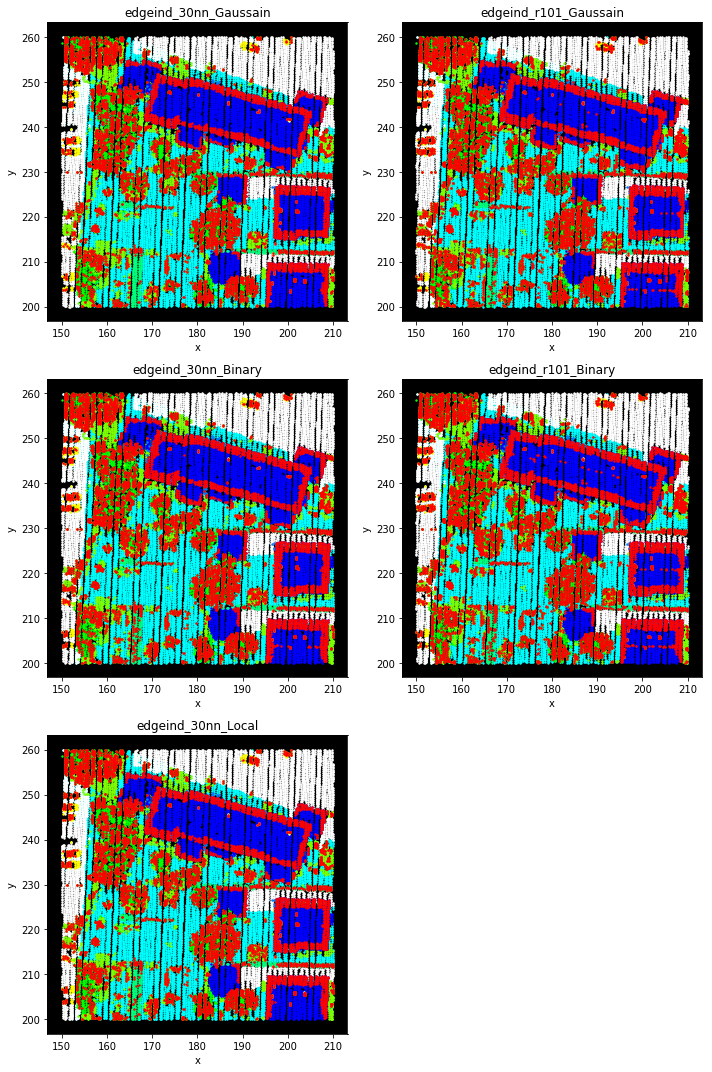

In [9]:
threshold_nn = 0.2
threshold_r  = 0.1

# Create signal dictionary
signal_dict = dict.fromkeys(['s_30nn_Gaussain', 's_30nn_Binary', 's_30nn_Local',
                             's_r101_Gaussain', 's_r101_Binary'])
 
# Create edge index dictonary, highlight nodes that have high frequency
edge_dict = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_30nn_Binary', 'edgeind_30nn_Local',
                           'edgeind_r101_Gaussain', 'edgeind_r101_Binary'])

for i, j, k in zip(signal_dict.keys(), filter_dict.keys(), edge_dict.keys()):
    signal_dict[i] = filter_dict[j].filter(patch.z, method = 'chebyshev')
    if 'nn' in i:
        edge_dict[k] = signal_dict[i][:, -1] >= threshold_nn
    else:
        edge_dict[k] = signal_dict[i][:, -1] >= threshold_r

# Visulize POI
plt.figure(figsize=(10,15))
axes = []
for i in range(5):
    axes.append(plt.subplot2grid((3,2), (i%3, int(i/3)), colspan=1))
for i, j in zip(edge_dict.keys(), axes):               
    if 'nn' in i:
        gspplot.plot_vaihingen_2D(patch, 
                                  id_highlight=np.nonzero(edge_dict[i])[0], 
                                  ax=j, 
                                  label_high='Edges',
                                  title="{}".format(i))
    else:
        gspplot.plot_vaihingen_2D(patch, 
                                  id_highlight=np.nonzero(edge_dict[i])[0], 
                                  ax=j, 
                                  label_high='Edges',
                                  title="{}".format(i))
plt.tight_layout()

## 3.4 Setting Ground Truth

I use the 30nn Binary graph to prepare for the ground truth. The signal value of the building nodes is 1, while that of other nodes is 0.

It is noticed that some points in the body of the buildings come out. They seem to surround the powerline points. So I do the following procedures: 1) If the nodes belong to roofs or powerlines, set the signal to be 1. 2) Remove the positive false points after filtering the signal. We cannot delete those powerline points in the dataframe because the indices are changed in this way. 

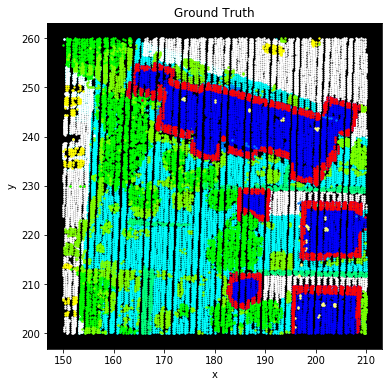

In [10]:
df2, edge_roof = set_ground_truth(patch=patch, threshold=0.08, f=filter_dict['g_MH_30nn_Binary'])


## 3.5 Graph Quantitative Comparison

The table below shows what the highligted points are composed of in each type of the graph. The column named total calculte the total number of points that come out after filtering in each graph representation. Other columns like precision and recall are calculated in the following way:

Precision = $\frac{detected\ points\ \cap \ GT}{detected\ points}$  
Recall (reference to ground truth) = $\frac{detected\ points\ \cap \ GT}{GT}$  
Recall (reference to label) = $\frac{detected\ points\ \cap \ roof points}{roof\ points}$

In [11]:
comp_df(patch, edge_dict=edge_dict, labels=labels)

,Powerline,Low Vegetation,Impervious surfaces,Car,Fence/Hedge,Roof,Facade,Shrub,Tree
30nn_Gaussain,0.008738,0.000753,0.000000,0.014914,0.036607,0.327207,0.002561,0.111479,0.497740
30nn_Binary,0.007827,0.001565,0.000000,0.023480,0.039264,0.338116,0.001957,0.120141,0.467649
30nn_Local,0.008018,0.001244,0.000000,0.022671,0.038153,0.329970,0.002350,0.119298,0.478297
r101_Gaussain,0.007588,0.006468,0.000373,0.026371,0.040801,0.314591,0.002737,0.140938,0.460132
r101_Binary,0.007339,0.006497,0.000120,0.026468,0.043070,0.323989,0.002286,0.138835,0.451396


In [12]:
qua_comp_df(df =comp_df(patch, edge_dict=edge_dict, labels=labels),
            df2=df2,
            edge_roof=edge_roof, 
            edge_dict=edge_dict)

,Powerline,Low Vegetation,Impervious surfaces,Car,Fence/Hedge,Roof,Facade,Shrub,Tree,Total,Precision,Recall_GT,Recall_roof
r101_Binary,0.007339,0.006497,0.000120,0.026468,0.043070,0.323989,0.002286,0.138835,0.451396,8312,0.212825,0.808132,0.381337
r101_Gaussain,0.007588,0.006468,0.000373,0.026371,0.040801,0.314591,0.002737,0.140938,0.460132,8039,0.216196,0.793970,0.358114
30nn_Binary,0.007827,0.001565,0.000000,0.023480,0.039264,0.338116,0.001957,0.120141,0.467649,7666,0.220976,0.773869,0.367035
30nn_Local,0.008018,0.001244,0.000000,0.022671,0.038153,0.329970,0.002350,0.119298,0.478297,7234,0.231269,0.764276,0.338006
30nn_Gaussain,0.008738,0.000753,0.000000,0.014914,0.036607,0.327207,0.002561,0.111479,0.497740,6638,0.241488,0.732298,0.307562


The Precision column seems to give the completely opposite conclusion compared to the Recall_GT column. That is, when the Recall_GT rate is higher, we have less precision. This may seems a little confusing at first look. But when we look at the total points each type of graph has detected, we find that more points in total tend to leads to less precision. That explain this phenomenon.

In [13]:
# Use label 9 to represent roof edge
df3 = df2.copy()
df3.loc[df3['is_edge']==1, 'label'] = 9
labels2 = labels.copy()
labels2[9] = 'Edge'

# 4 Problem 1, learn N parameters

In [14]:
path_e, path_U, path_L = './data/eigenvalnorm.npy', './data/eigenvecnorm.npy', './data/laplacian.npy'
G_30nn_Binary_e, G_30nn_Binary_U, G_30nn_Binary_L = load_G_30nn_Binary(path_e, path_U, path_L, patch)

In [15]:
dirPath = "./data/p1normepoch50gamma1e-6label9/"
lossName = 'loss.npy'
errorName = 'trainerr.npy'
wName = 'w.npy'
poiName = "poi.npy"

#load data if available
if os.path.exists(dirPath+lossName) and os.path.exists(dirPath+errorName) \
and os.path.exists(dirPath+wName) and os.path.exists(dirPath+poiName):
    loss_list = np.load(dirPath+lossName)
    train_error_list = np.load(dirPath+errorName)
    w = torch.from_numpy(np.load(dirPath+wName)).float()
    poi = np.load(dirPath + poiName)
else:
    os.makedirs(dirPath, exist_ok=True)
    train_input  = generate_data_non_parametric(G_30nn_Binary_U, patch)
    train_target = torch.FloatTensor([int(i) for i in list(df3['label']==9)])
    w, train_error_list, loss_list = train_non_parametric_filter(50, train_input, train_target, G_30nn_Binary_e, 
                                                             edge_dict['edgeind_30nn_Binary'], filter_dict['g_MH_30nn_Binary'])
    poi = (train_input@w - 0.2>=0).numpy()
    np.save(dirPath+lossName, loss_list)
    np.save(dirPath+errorName, train_error_list)
    np.save(dirPath+wName, w.data.numpy())
    np.save(dirPath + poiName, poi)
    

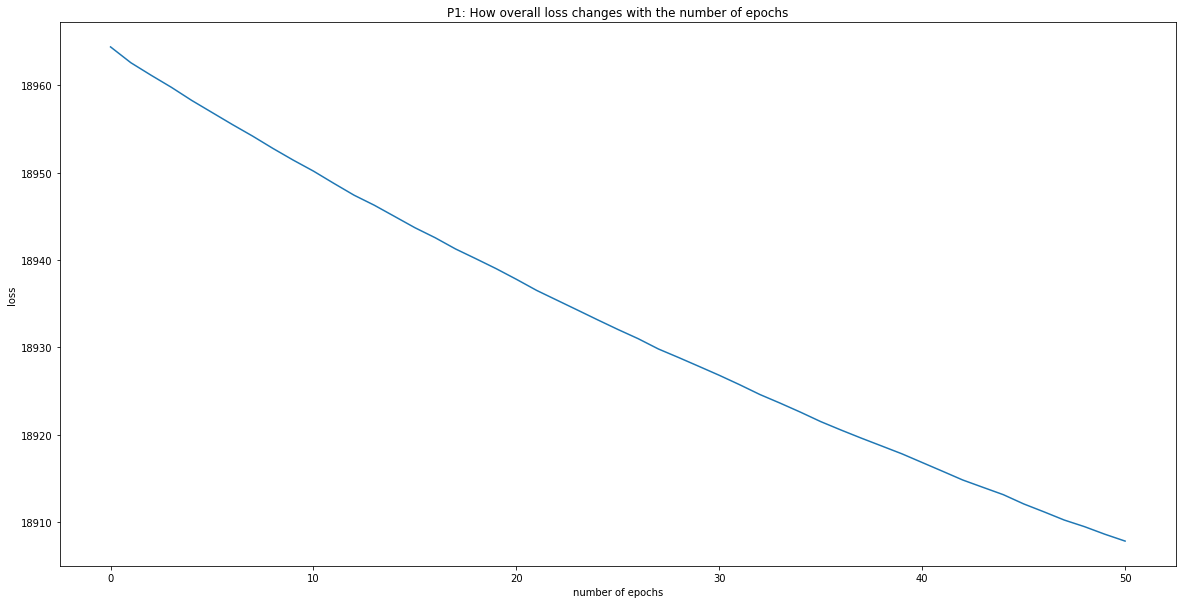

In [16]:
# Visualize the change of loss wrt epochs
fig = plt.figure(figsize=(20, 10))
plt.plot(loss_list)
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('P1: How overall loss changes with the number of epochs')
plt.show()

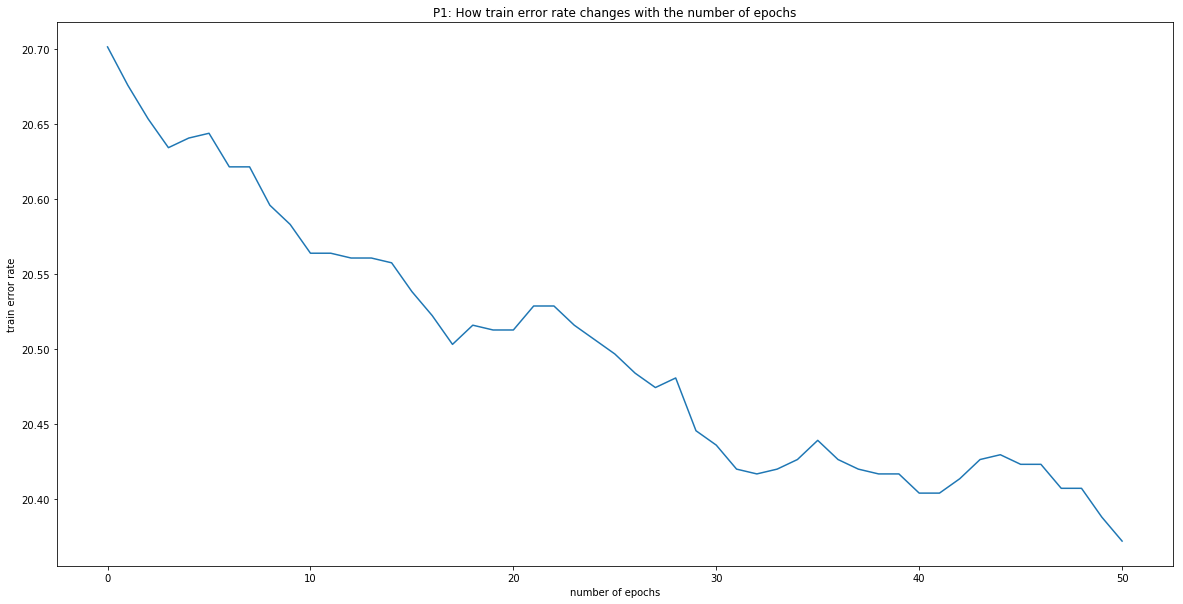

In [17]:
# Visualize the change of error wrt epochs
fig = plt.figure(figsize=(20, 10))
plt.plot(train_error_list)
plt.xlabel('number of epochs')
plt.ylabel('train error rate')
plt.title('P1: How train error rate changes with the number of epochs')
plt.show()

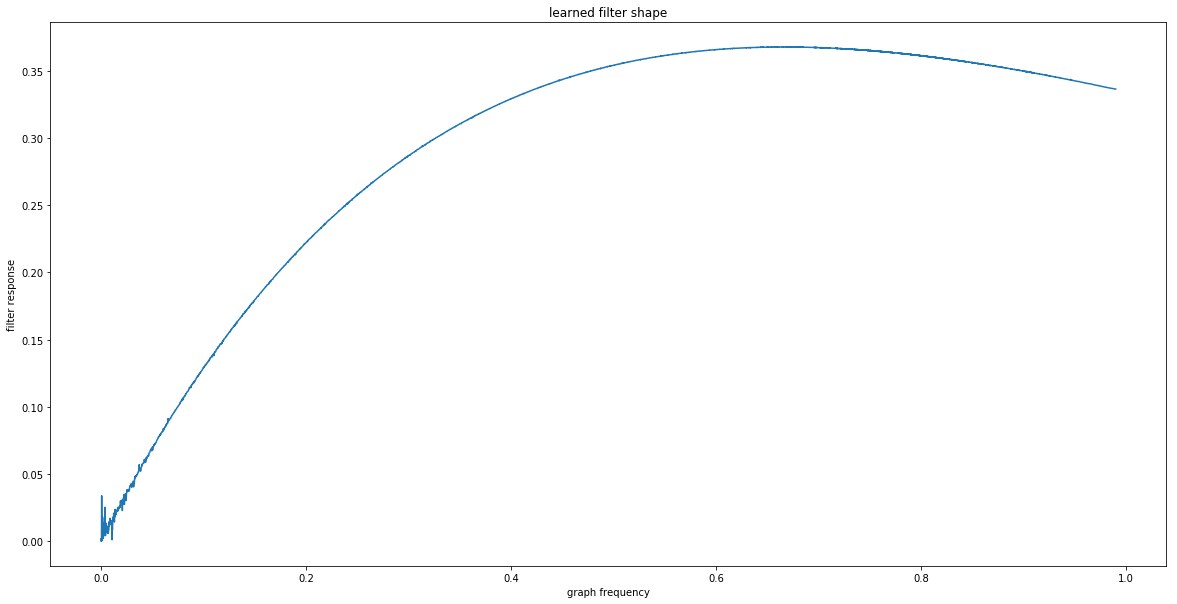

In [18]:
# Visualize the change of loss wrt graph frequency
fig = plt.figure(figsize=(20, 10))
plt.plot(G_30nn_Binary_e, w.data.numpy())
plt.xlabel("graph frequency")
plt.ylabel("filter response")
plt.title("learned filter shape")
plt.show()

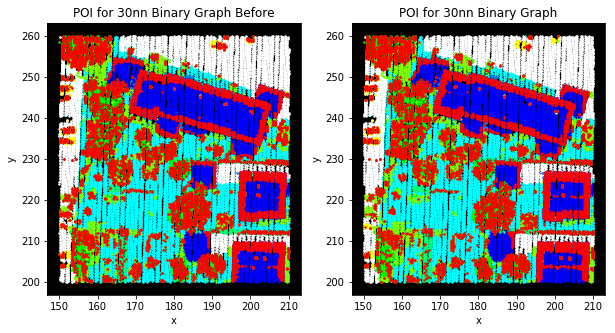

In [19]:
# Visualize POI
fig = plt.figure(figsize=(10, 5))
ax  = fig.add_subplot(1, 2, 1)
gspplot.plot_vaihingen_2D(patch, 
                          id_highlight=np.nonzero(edge_dict['edgeind_30nn_Binary'])[0], 
                          ax=ax,
                          label_high='Edges', 
                          title="POI for 30nn Binary Graph Before")
ax = fig.add_subplot(1, 2, 2)
gspplot.plot_vaihingen_2D(patch, 
                          id_highlight=np.nonzero(poi)[0], 
                          ax=ax,
                          label_high='Edges', 
                          title="POI for 30nn Binary Graph")

In [20]:
p1_df = recover_df({"poi": [bool(i) for i in poi], 'edgeind_30nn_Binary': edge_dict['edgeind_30nn_Binary']}, df3=df3, labels2=labels2, normalize=False)
type_error_roof(p1_df)

,poi,30nn_Binary,total
Powerline,59,60,62
Low Vegetation,6,12,8603
Impervious surfaces,0,0,5474
Car,149,180,300
Fence/Hedge,297,301,746
Roof,1025,898,4873
Facade,16,15,316
Shrub,823,921,3168
Tree,3523,3585,5508
Edge,1723,1694,2189


# 5 Problem 2, Mexican Hat Kernel Prior

In [21]:
dirPath = "./data/p2normepoch50gamma1e-6label9/"
lossName = 'loss.npy'
errorName = 'trainerr.npy'
wName = 'w.npy'
tauName = 'tau.npy'
tName = 't.npy'
poiName = "poi.npy"

#load data if available
if os.path.exists(dirPath+lossName) and os.path.exists(dirPath+errorName) and os.path.exists(dirPath+wName)\
and os.path.exists(dirPath+tauName) and os.path.exists(dirPath+tName) and os.path.exists(dirPath+poiName):
    loss_list2 = np.load(dirPath+lossName)
    train_error_list2 = np.load(dirPath+errorName)
    w2 = torch.from_numpy(np.load(dirPath+wName)).float()
    tau = torch.from_numpy(np.load(dirPath+tauName)).float()
    t2 = torch.from_numpy(np.load(dirPath+tName)).float()
    poi2 = np.load(dirPath + poiName)
else:
    os.makedirs(dirPath, exist_ok=True)
    train_input  = generate_data_mexican_hat(G_30nn_Binary_U, patch)
    train_target = torch.FloatTensor([int(i) for i in list(df3['label']==9)])
    # First, find a good filter shape without changing the threshold
    tau, t2, w2, train_error_list2, loss_list2 = train_mexican_hat(50, 
                                                               train_input, 
                                                               train_target, 
                                                               G_30nn_Binary_e,
                                                               signal_dict['s_30nn_Binary'],
                                                               edge_dict['edgeind_30nn_Binary'], 
                                                               gamma=1e-6, 
                                                               breakDetect=False)
    poi2 = (train_input@w2 - 0.2>=0).numpy()
    np.save(dirPath+lossName, loss_list2)
    np.save(dirPath+errorName, train_error_list2)
    np.save(dirPath+wName, w2.data.numpy())
    np.save(dirPath+tauName, tau.data.numpy())
    np.save(dirPath+tName, t2.data.numpy())
    np.save(dirPath+poiName, poi2)

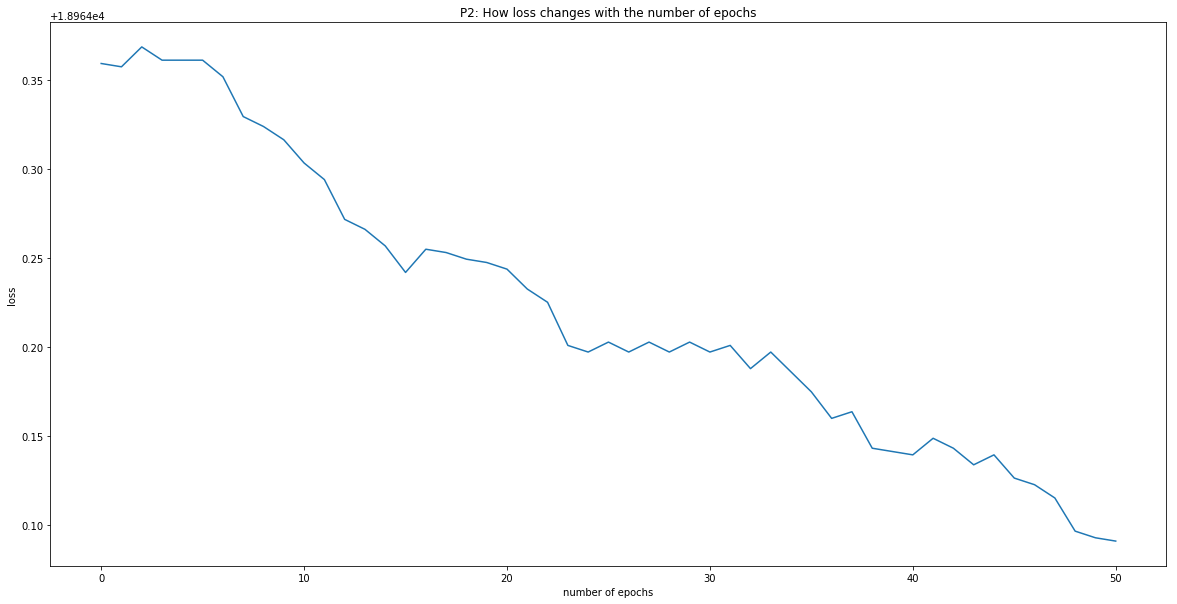

In [22]:
# Visualize the change of loss wrt epochs
fig = plt.figure(figsize=(20, 10))
plt.plot(loss_list2)
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('P2: How loss changes with the number of epochs')
plt.show()

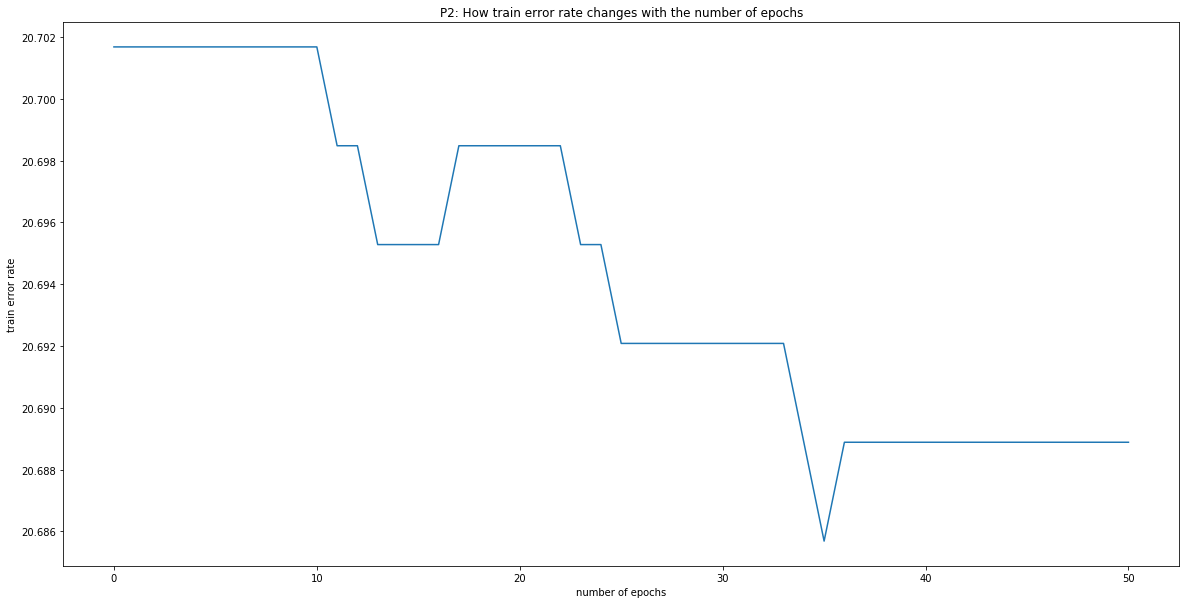

In [23]:
# Visualize the change of error wrt epochs
fig = plt.figure(figsize=(20, 10))
plt.plot(train_error_list2)
plt.xlabel('number of epochs')
plt.ylabel('train error rate')
plt.title('P2: How train error rate changes with the number of epochs')
plt.show()

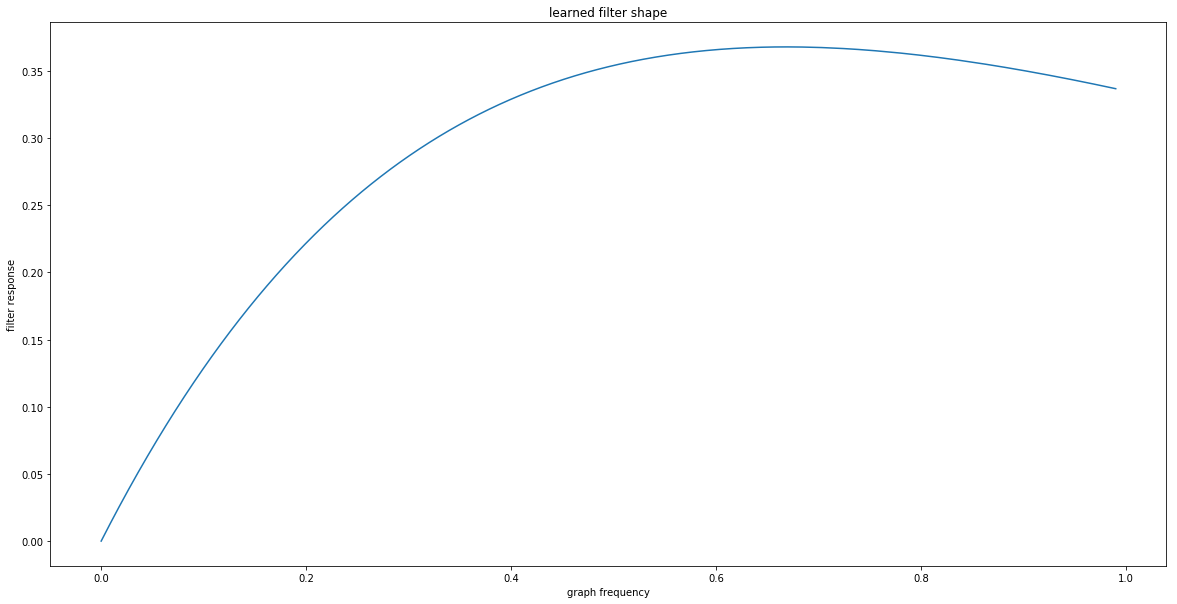

In [24]:
# Visualize the change of loss wrt graph frequency
fig = plt.figure(figsize=(20, 10))
plt.plot(G_30nn_Binary_e, w2.data.numpy())
plt.xlabel("graph frequency")
plt.ylabel("filter response")
plt.title("learned filter shape")
plt.show()

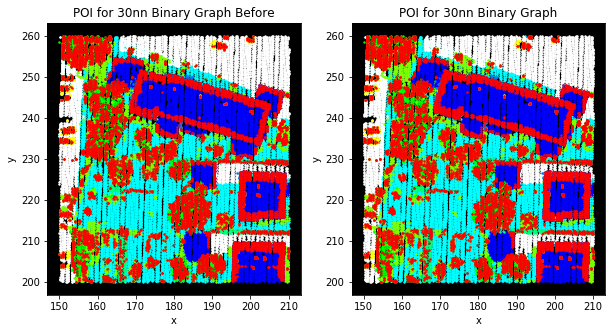

In [25]:
# Visualize POI
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
gspplot.plot_vaihingen_2D(patch, 
                          id_highlight=np.nonzero(edge_dict['edgeind_30nn_Binary'])[0], 
                          ax=ax,
                          label_high='Edges', 
                          title="POI for 30nn Binary Graph Before")
ax=ax = fig.add_subplot(1, 2, 2)
gspplot.plot_vaihingen_2D(patch, 
                          id_highlight=np.nonzero(poi2)[0], 
                          ax=ax,
                          label_high='Edges', 
                          title="POI for 30nn Binary Graph")

In [26]:
p2_df = recover_df({"poi": [bool(i) for i in poi2], 'edgeind_30nn_Binary': edge_dict['edgeind_30nn_Binary']}, df3=df3, labels2=labels2, normalize=False)
type_error_roof(p2_df)

,poi,30nn_Binary,total
Powerline,60,60,62
Low Vegetation,12,12,8603
Impervious surfaces,0,0,5474
Car,180,180,300
Fence/Hedge,300,301,746
Roof,896,898,4873
Facade,15,15,316
Shrub,921,921,3168
Tree,3584,3585,5508
Edge,1694,1694,2189


# 6 Problem 3,  Polynomial Approximation

In [27]:
torch.set_printoptions(precision=10)
#set different learning rates for different parameters

In this problem, I use polynomial terms to approximate the filter kernel. I don't use the constant term, the coefficient for it would be very very small. The threshold is fixed to be 0.2 right now.

In [28]:
dirPath = './data/p3_diff_k_label9/' 
lossName = 'loss.npy'
errorName = 'trainerr.npy'
alphaName = 'alpha.npy'
poiName = 'poi.npy'
tName = 't.npy'
orderList    = [3, 5, 7, 9, 15]

# Define variables
var                = locals()
train_input3_k     = lambda s: 'train_input3_k%s'% s
x_k, t3_k, alpha_k = lambda s: 'x_k%s'% s, lambda s: 't3_k%s'% s, lambda s: 'alpha_k%s'% s
loss_list3_k       = lambda s: 'loss_list3_k%s'% s
train_error_list3_k= lambda s: 'train_error_list3_k%s'% s
    
#load data if available
if os.path.exists(dirPath+lossName) and os.path.exists(dirPath+errorName) and os.path.exists(dirPath+alphaName)\
and os.path.exists(dirPath+tName) and os.path.exists(dirPath+poiName):
    loss_list3_k3, loss_list3_k5, loss_list3_k7, loss_list3_k9, loss_list3_k15 = np.load(dirPath+lossName)
    train_error_list3_k3, train_error_list3_k5, train_error_list3_k7, train_error_list3_k9, train_error_list3_k15 = np.load(dirPath+errorName)
    alpha_k3, alpha_k5, alpha_k7, alpha_k9, alpha_k15 = np.load(dirPath + alphaName)
    t3_k3, t3_k5, t3_k7, t3_k9, t3_k15 = np.load(dirPath + tName)
    poi_list = np.load(dirPath + poiName)
    for i in orderList:
        var[x_k(i)] = poly_e(G_30nn_Binary_e, i)
    
else: 
    os.makedirs(dirPath, exist_ok=True)
    epochs       = 50
    train_target = torch.FloatTensor([int(i) for i in list(df3['label']==9)])
                                     
    # Train filters with different parameters
    for order in orderList:
    # Generate polynomial input
        var[train_input3_k(order)] = generate_data_poly(patch, G_30nn_Binary_L, order)
        # Fix threshold, only learn filter shape
        var[x_k(order)], var[alpha_k(order)], var[t3_k(order)],\
        var[train_error_list3_k(order)], var[loss_list3_k(order)] = train_polynomial_kernel(epochs, var[train_input3_k(order)], train_target, order, 
                                                                                            G_30nn_Binary_e, filter_dict['g_MH_30nn_Binary'], 
                                                                                            alter_thresh=False, scheduler_flag=True)

    np.save(dirPath+lossName, (loss_list3_k3, loss_list3_k5, loss_list3_k7, loss_list3_k9, loss_list3_k15)) 
    np.save(dirPath+errorName, (train_error_list3_k3, train_error_list3_k5, train_error_list3_k7, train_error_list3_k9, train_error_list3_k15)) 
    poi_list= []
    for order in orderList:
        poi_list.append((var[train_input3_k(order)].mv(var[alpha_k(order)]) - var[t3_k(order)] >= 0).numpy())
    np.save(dirPath + poiName, poi_list)
    np.save(dirPath+alphaName, (alpha_k3, alpha_k5, alpha_k7, alpha_k9, alpha_k15))
    np.save(dirPath+tName, (t3_k3, t3_k5, t3_k7, t3_k9, t3_k15))
    

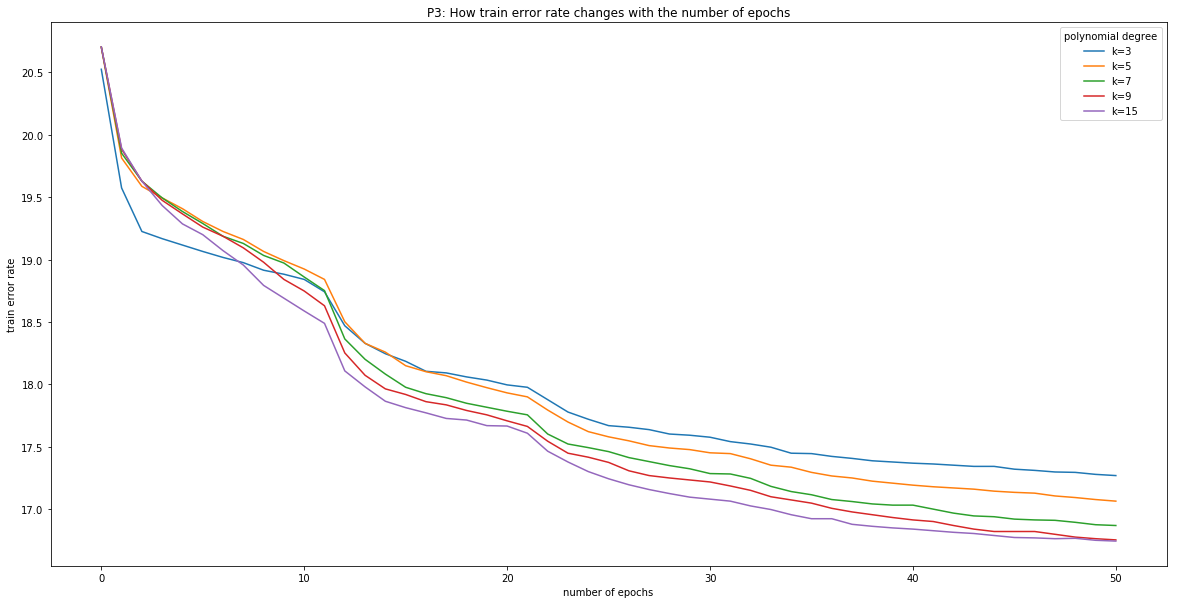

In [29]:
# Visualize the change of train error rate wrt epochs
fig = plt.figure(figsize=(20, 10))
for order in orderList:
    plt.plot(var[train_error_list3_k(order)], label='k={}'.format(order))
plt.legend(title='polynomial degree')
plt.xlabel('number of epochs')
plt.ylabel('train error rate')
plt.title('P3: How train error rate changes with the number of epochs')
plt.show()

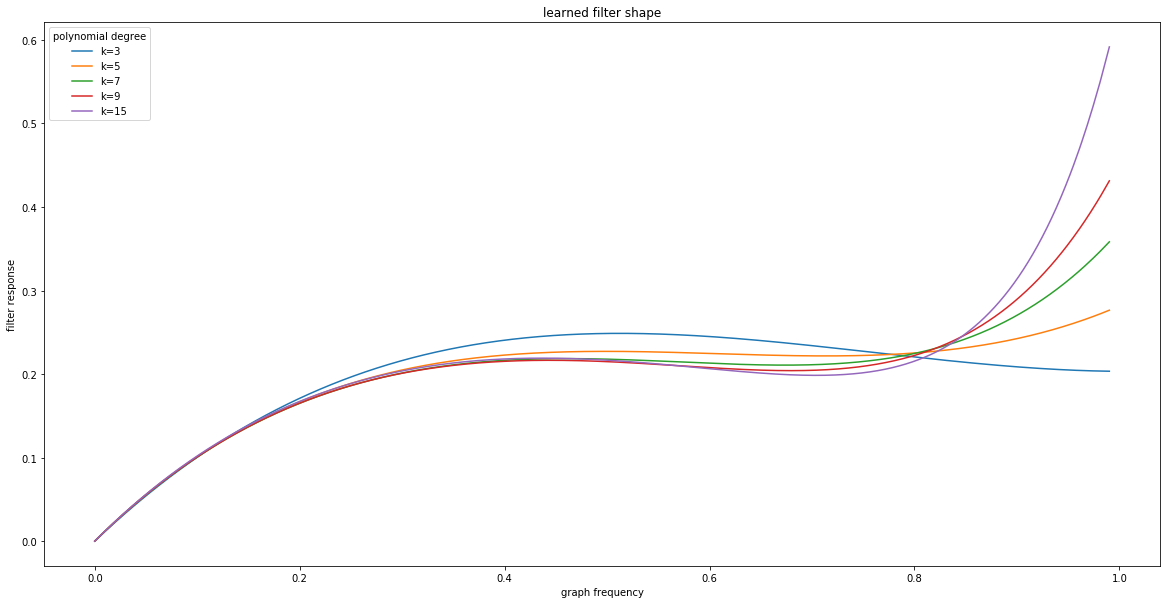

In [30]:
# Visualize the filter shape
fig = plt.figure(figsize=(20, 10))
for order in orderList:
    plt.plot(G_30nn_Binary_e, var[x_k(order)]@var[alpha_k(order)].data.numpy(), label='k={}'.format(order))
plt.legend(title='polynomial degree')
plt.xlabel("graph frequency")
plt.ylabel("filter response")
plt.title("learned filter shape")
plt.show()

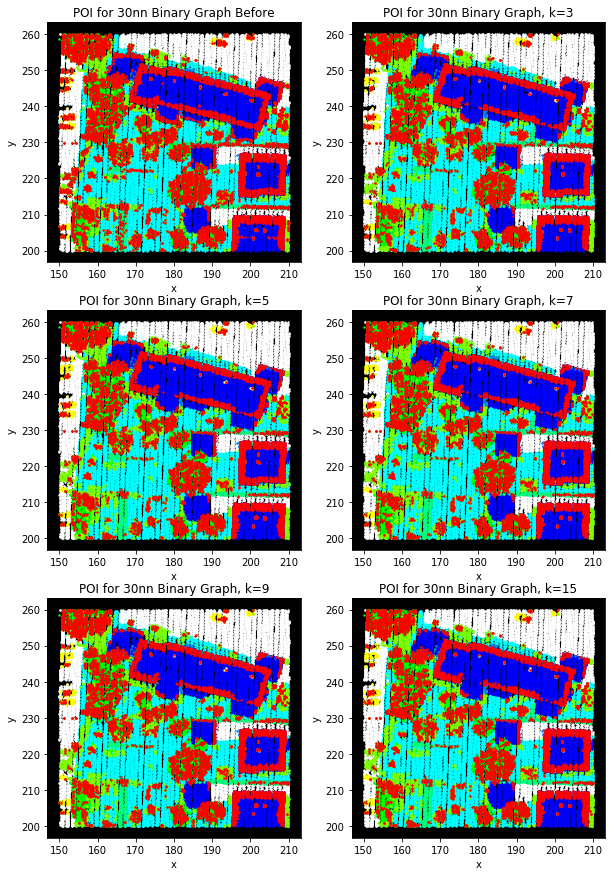

In [31]:
# The threshold is fixed to be 0.2 actually

# Visulize POI
fig = plt.figure(figsize=(10, 15))
ax  = fig.add_subplot(3, 2, 1)
gspplot.plot_vaihingen_2D(patch, 
                          id_highlight=np.nonzero(edge_dict['edgeind_30nn_Binary'])[0], 
                          ax=ax,
                          label_high='Edges', 
                          title="POI for 30nn Binary Graph Before")
for i,j in zip(range(2, 7), orderList):
    ax = fig.add_subplot(3, 2, i)
    gspplot.plot_vaihingen_2D(patch, 
                              id_highlight=np.nonzero(poi_list[i-2])[0], 
                              ax=ax,
                              label_high='Edges', 
                              title="POI for 30nn Binary Graph, k={}".format(j))

Learning threshold is not that important and we are more interested in filter shape. In fact, after learning paramter alpha, we can set threshold manually. The bigger the threshold, the fewer points we detect. Type 1 error lowers and Type 2 error goes up.

In [32]:
poi_str = ['poi3_k3', 'poi3_k5', 'poi3_k7', 'poi3_k9', 'poi3_k15']
poi_df = {'edgeind_30nn_Binary': edge_dict['edgeind_30nn_Binary']}
for i in range(5):
    poi_df.update({poi_str[i]: [bool(j) for j in poi_list[i]]})
p3_df = recover_df(poi_df, normalize=False, df3=df3, labels2=labels2)
type_error_roof(p3_df)

,30nn_Binary,k3,k5,k7,k9,k15,total
Powerline,60,53,52,51,51,52,62
Low Vegetation,12,1,1,0,0,0,8603
Impervious surfaces,0,0,0,0,0,0,5474
Car,180,92,80,75,70,71,300
Fence/Hedge,301,164,142,131,124,124,746
Roof,898,702,684,676,667,672,4873
Facade,15,7,7,7,8,8,316
Shrub,921,529,506,488,482,483,3168
Tree,3585,3153,3152,3123,3102,3086,5508
Edge,1694,1495,1482,1470,1459,1454,2189


# Post-processing and Patch Alignment

We build graph representations only on the red points. Then we calculate LZ=Y, where Z is the graph signal composed of Z coordinate. The edge points of a roof are almost at the same level, but the neighboring tree points are more fluctuating. So for roof edge result, we keep those points that have small $\left|y\right|$. For tree result, we keep points that have large $\left|y\right|$. This postprocessing step aims at enhancing the performance of a single filter.

In [33]:
# Define a polynomial function
def poly_freq(x, alpha):
    poly_x = []
    for i in range(15):
        poly_x.append(x**(i+1))
    return alpha@poly_x


# crop filter validation patch and detect POI
patch2 = crop_patch(newcloud, (150, 210), (150, 210))
patch_list = [patch, patch2]
G_30nn_Binary2, _ = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                  mode='connectivity', neightype='number', lap_type='combinatorial', norm=True)
filter_roof2 = filters.Filter(G_30nn_Binary2, lambda x: poly_freq(x, alpha_k15.data.numpy()))
signal_roof2 = filter_roof2.filter(patch2.z, method='chebyshev')
edge_roof2 = signal_roof2 >= 0.2

# keep POI in patches 
patch_roof1 = patch.reset_index()[poi_df['poi3_k15']]
patch_roof2 = patch2.reset_index()[edge_roof2]
patch_list2 = [patch_roof1, patch_roof2]

# create 30nn binary graph based on POI
G_30nn_roof1, _ = gsp.knn_graph(cloud=patch_roof1[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='connectivity', neightype='number', lap_type='combinatorial', norm=True)
G_30nn_roof2, _ = gsp.knn_graph(cloud=patch_roof2[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='connectivity', neightype='number', lap_type='combinatorial', norm=True)
graph_list2 = [G_30nn_roof1, G_30nn_roof2]
for graph in graph_list2:
    graph.compute_laplacian('combinatorial')

# keep less fluctuating points
signal_dict2 = dict.fromkeys(['roof1', 'roof2'])
poi_dict2 = dict.fromkeys(['roof1', 'roof2'])
poi_dict3 = dict.fromkeys(['roof1', 'roof2'])
for key, i in zip(signal_dict2.keys(), range(2)):
    signal_dict2[key] = graph_list2[i].L@patch_list2[i].z
    poi_dict2[key] = np.abs(signal_dict2[key]) < 0.15
    index = patch_list2[i][poi_dict2[key]].index
    tmp = np.zeros(len(patch_list[i]))
    tmp[index] = 1
    poi_dict3[key] = np.array([bool(k) for k in tmp])
    


-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[150, 210], y:[150, 210].
=> Points left for patch: 31882.
----------------------------------------------------


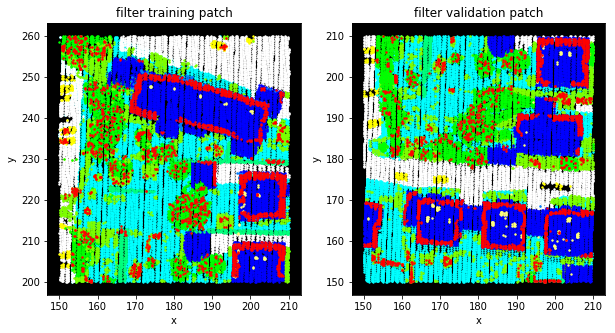

In [34]:
# The performance of the roof filter on the filter training patch and the filter validation patch
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
title_list  = ['filter training patch', 'filter validation patch']
for key, i in zip(poi_dict3.keys(), range(2)):
    gspplot.plot_vaihingen_2D(patch_list[i], 
                              id_highlight=np.nonzero(poi_dict3[key])[0], 
                              ax=axes[i], 
                              label_high='Edges', 
                              title=title_list[i])


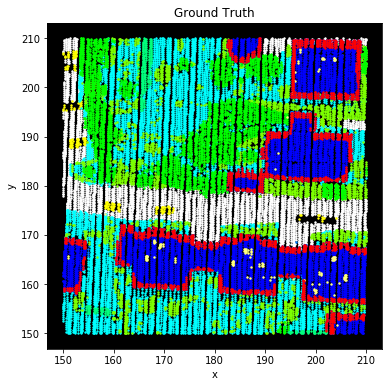

In [35]:
# Set ground truth for filter validation patch
filter_high = filters.Filter(G_30nn_Binary2, lambda x: 1.5*x*np.exp(-1.5*x))
df_patch2, edge_roof2 = set_ground_truth(patch=patch2, threshold=0.08, f=filter_high)


In [36]:
# for quantitative comparison
df3_patch2 = df_patch2.copy()
df3_patch2.loc[df_patch2['is_edge']==1, 'label'] = 9
 

In [37]:
# for filter training patch
type_error_roof(recover_df({'poi_roof':poi_dict3['roof1']}, 
                df3=df3, labels2=labels2, normalize=False))


,roof,total
Powerline,2,62
Low Vegetation,0,8603
Impervious surfaces,0,5474
Car,34,300
Fence/Hedge,40,746
Roof,442,4873
Facade,1,316
Shrub,188,3168
Tree,826,5508
Edge,1042,2189


In [38]:
# for filter validation patch
type_error_roof(recover_df({'poi_roof':poi_dict3['roof2']}, 
                df3=df3_patch2, labels2=labels2, normalize=False))

,roof,total
Powerline,3,149
Low Vegetation,0,9245
Impervious surfaces,0,4559
Car,0,216
Fence/Hedge,79,357
Roof,577,6227
Facade,15,584
Shrub,331,4162
Tree,441,3975
Edge,1141,2408
